In [ ]:
PATH_DRIVE = '/content/drive'
PATH_DRIVE_TP = PATH_DRIVE + '/MyDrive/TP_Datos_2C2021/parte_2'
PATH_DRIVE_TP_PREDICCIONES = PATH_DRIVE_TP + '/predicciones'

KNN_IMPUTER_COMPUTAR = False
KNN_IMPUTER_PATH_VALUES = PATH_DRIVE_TP + '/imputaciones/hamburguesas_values_knn.csv'
KNN_IMPUTER_PATH_VAL_DEV = PATH_DRIVE_TP + '/imputaciones/hamburguesas_val_dev_knn.csv'
KNN_IMPUTER_PATH_TEST = PATH_DRIVE_TP + '/imputaciones/hamburguesas_test_knn.csv'

In [ ]:
from google.colab import drive
import sys

drive.mount(PATH_DRIVE, force_remount=True)
sys.path.insert(0, PATH_DRIVE_TP)

Mounted at /content/drive


In [ ]:
!pip install category_encoders

from preprocessing import *

     |████████████████████████████████| 82 kB 296 kB/s 


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

#Librerías de métricas
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score

# haciendo los graficos un poco mas bonitos en matplotlib
plt.style.use('default') 
#plt.rcParams['figure.figsize'] = (20, 10)

plt.rcParams['figure.dpi'] = 150

# seteando tipo de grid en seaborn
sns.set_theme(style='ticks', palette=None, font_scale=.9) 

In [ ]:
VALUES_URL = 'https://docs.google.com/spreadsheets/d/1wduqo5WyYmCpaGnE81sLNGU0VSodIekMfpmEwU0fGqs'
TARGET_URL = 'https://docs.google.com/spreadsheets/d/1gvZ03uAL6THwd04Y98GtIj6SeAHiKyQY5UisuuyFSUs'
TEST_URL = 'https://docs.google.com/spreadsheets/d/1mR_JNN0-ceiB5qV42Ff9hznz0HtWaoPF3B9zNGoNPY8'

hamburguesas_values, hamburguesas_target, hamburguesas_test = descargar_datasets(
    VALUES_URL, 
    TARGET_URL, 
    TEST_URL
  )

In [ ]:
#Split en mi dataset de train y mi dataset de test
X_train, X_test, y_train, y_test = train_test_split(
    hamburguesas_values, 
    hamburguesas_target, 
    test_size=0.4,
    random_state=66, 
    stratify=hamburguesas_target.astype(str)
)

#Split en mi dataset de val_dev y test_holdout
X_val_dev, X_test_holdout, y_val_dev, y_test_holdout = train_test_split(
    X_test, 
    y_test, 
    test_size=0.1,
    random_state=66, 
    stratify=y_test.llovieron_hamburguesas_al_dia_siguiente.astype(str)
)

### Búsqueda de hiperparámetros del Modelo

In [ ]:
def computar_mejores_hiperparametros(model, hiperparametros, X_train, y_train):
  model_cv = GridSearchCV(
      estimator = model,
      param_grid = hiperparametros,
      scoring='roc_auc',
      cv=5, 
      verbose=3
  )

  model_cv.fit(X_train, y_train)

  return model_cv.best_params_

Armo el diccionario de hiperparámetros que vamos a buscar

In [ ]:
max_depth_range = np.arange(1, 31, 5)
min_samples_leaf_range = np.arange(1, 16, 2)

hiperparametros_a_buscar = dict(
    max_depth = max_depth_range,
    min_samples_leaf = min_samples_leaf_range
)

### Funciones utiles para métricas

In [ ]:
def show_metrics_values(y_true, y_pred):
  valor_metrica = roc_auc_score(y_true, y_pred, average='micro')
  print(f'ROC AUC Score {valor_metrica}')
  
  valor_metrica = accuracy_score(y_true, y_pred)
  print(f'Accuracy Score {valor_metrica}')

  valor_metrica = precision_score(y_true, y_pred)
  print(f'Precision Score {valor_metrica}')

  valor_metrica = recall_score(y_true, y_pred)
  print(f'Recall Score {valor_metrica}')

  valor_metrica = f1_score(y_true, y_pred)
  print(f'F1 Score {valor_metrica}')
  

def plot_confusion_matrix(y_true, y_pred):
  names = sorted(set(y_true))
  cm = confusion_matrix(y_true, y_pred)
  df_cm = pd.DataFrame(cm, names, names)

  plt.figure(dpi=100)
  plt.title("Matriz de confusion")
  sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='g', square=True)
  plt.ylabel("True label")
  plt.xlabel("Predicted label")
  plt.show()


def plot_roc(_fpr, _tpr, x):
  roc_auc = auc(_fpr, _tpr)

  plt.figure(figsize=(12, 6), dpi=100)
  plt.plot(
      _fpr, _tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})'
  )
  plt.scatter(_fpr, x)
  plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Receiver operating characteristic')
  plt.legend(loc="lower right")
  plt.show()

## KnnImputer - Standar Scaler - One Hot Encoding con Hashing Trick

Hago el encoding de mis dataset

In [ ]:
hamburguesas_train_values_ht, hamburguesas_val_dev_values_ht, X_test_holdout_sn = preprocessing_knn_imputer_standar_escaler_one_hot_encoding_hashing_trick(
    X_train, 
    X_val_dev, 
    X_test_holdout
)

#hamburguesas_train_values_ht = hashing_trick_ecoding(hamburguesas_values_escalado)
#hamburguesas_train_target_enc = y_train.llovieron_hamburguesas_al_dia_siguiente.map({'No': 0, 'Si': 1, np.NaN: 0})

#hamburguesas_val_dev_values_ht = hashing_trick_ecoding(hamburguesas_val_dev_escalado)
#hamburguesas_val_dev_target_enc = y_val_dev.llovieron_hamburguesas_al_dia_siguiente.map({'No': 0, 'Si': 1, np.NaN: 0})

In [ ]:
hamburguesas_train_target_enc = y_train.llovieron_hamburguesas_al_dia_siguiente.map({'no': 0, 'si': 1, np.NaN: 0})
hamburguesas_val_dev_target_enc = y_val_dev.llovieron_hamburguesas_al_dia_siguiente.map({'no': 0, 'si': 1, np.NaN: 0})

Busco los hiperparametros de mi modelo

In [ ]:
model = DecisionTreeClassifier()

hiperparametros = computar_mejores_hiperparametros(
    model = model, 
    hiperparametros = hiperparametros_a_buscar, 
    X_train = hamburguesas_train_values_ht, 
    y_train = hamburguesas_train_target_enc
)

hiperparametros

Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV 1/5] END ...max_depth=1, min_samples_leaf=1;, score=0.665 total time=   0.1s
[CV 2/5] END ...max_depth=1, min_samples_leaf=1;, score=0.668 total time=   0.1s
[CV 3/5] END ...max_depth=1, min_samples_leaf=1;, score=0.695 total time=   0.1s
[CV 4/5] END ...max_depth=1, min_samples_leaf=1;, score=0.679 total time=   0.1s
[CV 5/5] END ...max_depth=1, min_samples_leaf=1;, score=0.674 total time=   0.1s
[CV 1/5] END ...max_depth=1, min_samples_leaf=3;, score=0.665 total time=   0.1s
[CV 2/5] END ...max_depth=1, min_samples_leaf=3;, score=0.668 total time=   0.1s
[CV 3/5] END ...max_depth=1, min_samples_leaf=3;, score=0.695 total time=   0.1s
[CV 4/5] END ...max_depth=1, min_samples_leaf=3;, score=0.679 total time=   0.1s
[CV 5/5] END ...max_depth=1, min_samples_leaf=3;, score=0.674 total time=   0.1s
[CV 1/5] END ...max_depth=1, min_samples_leaf=5;, score=0.665 total time=   0.1s
[CV 2/5] END ...max_depth=1, min_samples_leaf=5

{'max_depth': 6, 'min_samples_leaf': 11}

In [ ]:
modelo = DecisionTreeClassifier(**hiperparametros)
modelo.fit(hamburguesas_train_values_ht, hamburguesas_train_target_enc)

DecisionTreeClassifier(max_depth=6, min_samples_leaf=11)

Obtengo las predicciones de mi modelo

In [ ]:
predictions = modelo.predict(hamburguesas_val_dev_values_ht)

#### Métricas del modelo

Los valores de las métricas mas usadas son los siguientes:

In [ ]:
show_metrics_values(hamburguesas_val_dev_target_enc, predictions)

ROC AUC Score 0.7010423342190819
Accuracy Score 0.8383262120163273
Precision Score 0.6994654193117273
Recall Score 0.4570461739984718
F1 Score 0.5528487489271803


Veo la curva ROC, sabiendo que AUC es aproximadamente 0.70 segundo lo obtenido líneas arriba

array([0.        , 0.05496151, 1.        ])

array([0.        , 0.45704617, 1.        ])

array([2, 1, 0])

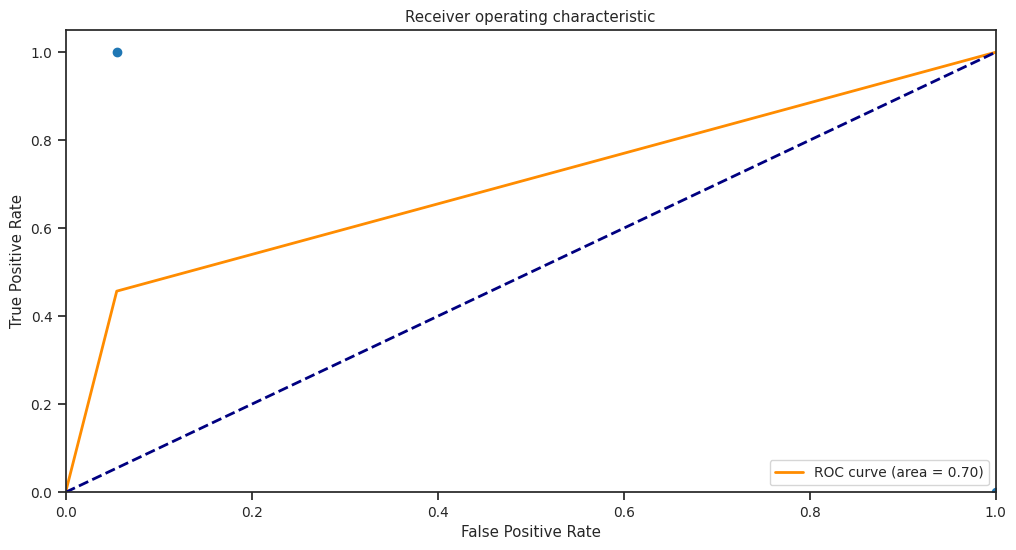

In [ ]:
fpr, tpr, thresholds = roc_curve(hamburguesas_val_dev_target_enc, predictions)

display(fpr)
display(tpr)
display(thresholds)

plot_roc(fpr, tpr, thresholds)

Vemos la matriz de confusión de nuestro modelo

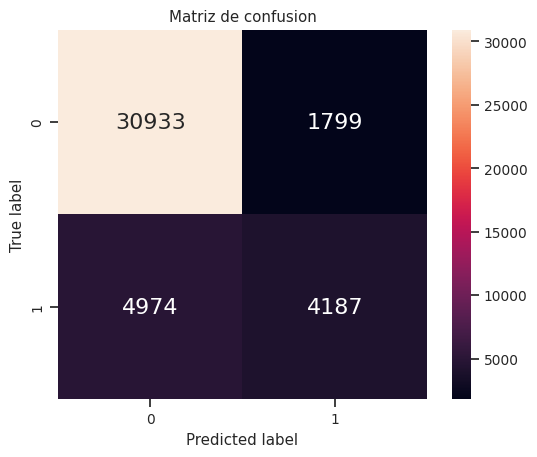

In [ ]:
plot_confusion_matrix(hamburguesas_val_dev_target_enc, predictions)

La matriz de confusion nos muestra nuestros $tp$ (verdaderos positivos, arriba a la izquierda), $fp$ (falsos positivos, abajo a la izquierda), $tn$ (verdaderos negativos, abajo a la derecha) y $fn$ (falsos negativos, arriba a la derecha) en una matriz.

En este caso, la tendencia del modelo es que tiende a predecir 0 sobre 1 porque si vemos la otra diagonal (la de "pifiadas") vemos que hay más casos de era 1 y lo predijo como 0, respecto de era 0 y lo predijo como 1. Por otro lado, la diagonal principal, es "saludable" pero no tanto, pues hay una diferencia muy alta entre los casos en los que era 0 y predijo 0 respecto de los de la otra diagonal pero no sucedió lo mismo en los casos en los que era 1 y predijo 1 (es bastante mayor que en era 0 y predijo 1 pero un poco menor que en era 1 y predijo 0). 

El modelo predijo bien más positivos (35907 casos, 85,71%) que negativos (5986 casos, 14,29%) porque hay una gran cantidad de verdaderos positivos y (en menor medida) falsos positivos, mientras que los verdaderos negativos y falsos negativos hay menos.

Guardamos las predicciones del modelo

In [ ]:
conversion_features_dataset(hamburguesas_test)

hamburguesas_test_sn = knn_imputer(None, None, None, hamburguesas_test, True)
hamburguesas_test_escalado = standar_scaler(hamburguesas_test_sn)
hamburguesas_test_sin_barrio = hashing_trick_encoding(hamburguesas_test_escalado)
hamburguesas_test_ht = one_hot_encoding(hamburguesas_test_sin_barrio)

predicciones = modelo.predict(hamburguesas_test_ht)

In [ ]:
auxiliar = hamburguesas_test.join(hamburguesas_target).reset_index()
auxiliar = auxiliar[['id', 'llovieron_hamburguesas_al_dia_siguiente']]
auxiliar = auxiliar.set_index('id')

nuestra_prediccion = pd.DataFrame(data=predicciones, columns=auxiliar.columns, index=auxiliar.index)

for v in nuestra_prediccion.columns:
  nuestra_prediccion.loc[:, v] = nuestra_prediccion[v].map({0: 'no', 1: 'si',})

nuestra_prediccion.to_csv(PATH_DRIVE_TP_PREDICCIONES + '/decision_tree_knn_imputer_standar_scaler_ohe_ht.csv')

## KnnImputer - Standar Scaler - One Hot Encoding con Binary encoding

Hago el encoding de mis dataset

In [ ]:
hamburguesas_train_values_bin, hamburguesas_val_dev_values_bin, X_test_holdout_sn = preprocessing_knn_imputer_standar_escaler_one_hot_encoding_binary_encoding(
    X_train, 
    X_val_dev, 
    X_test_holdout
)

In [ ]:
hamburguesas_train_target_enc = y_train.llovieron_hamburguesas_al_dia_siguiente.map({'no': 0, 'si': 1, np.NaN: 0})
hamburguesas_val_dev_target_enc = y_val_dev.llovieron_hamburguesas_al_dia_siguiente.map({'no': 0, 'si': 1, np.NaN: 0})

Busco los hiperparametros de mi modelo

In [ ]:
model = DecisionTreeClassifier()

hiperparametros = computar_mejores_hiperparametros(
    model = model, 
    hiperparametros = hiperparametros_a_buscar, 
    X_train = hamburguesas_train_values_bin, 
    y_train = hamburguesas_train_target_enc
)

hiperparametros

Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV 1/5] END ...max_depth=1, min_samples_leaf=1;, score=0.665 total time=   0.1s
[CV 2/5] END ...max_depth=1, min_samples_leaf=1;, score=0.668 total time=   0.1s
[CV 3/5] END ...max_depth=1, min_samples_leaf=1;, score=0.695 total time=   0.1s
[CV 4/5] END ...max_depth=1, min_samples_leaf=1;, score=0.679 total time=   0.1s
[CV 5/5] END ...max_depth=1, min_samples_leaf=1;, score=0.674 total time=   0.1s
[CV 1/5] END ...max_depth=1, min_samples_leaf=3;, score=0.665 total time=   0.1s
[CV 2/5] END ...max_depth=1, min_samples_leaf=3;, score=0.668 total time=   0.1s
[CV 3/5] END ...max_depth=1, min_samples_leaf=3;, score=0.695 total time=   0.1s
[CV 4/5] END ...max_depth=1, min_samples_leaf=3;, score=0.679 total time=   0.1s
[CV 5/5] END ...max_depth=1, min_samples_leaf=3;, score=0.674 total time=   0.1s
[CV 1/5] END ...max_depth=1, min_samples_leaf=5;, score=0.665 total time=   0.1s
[CV 2/5] END ...max_depth=1, min_samples_leaf=5

{'max_depth': 6, 'min_samples_leaf': 7}

Dropeamos `barrio_4` de hamburguesas_train_values_bin para poder hacer la predicción porque esta sobrando luego de hacer el standar scaler:

In [ ]:
hamburguesas_train_values_bin.drop(labels='barrio_4', axis=1, inplace=True)

In [ ]:
modelo = DecisionTreeClassifier(**hiperparametros)
modelo.fit(hamburguesas_train_values_bin, hamburguesas_train_target_enc)

DecisionTreeClassifier(max_depth=6, min_samples_leaf=7)

Obtengo las predicciones de mi modelo

In [ ]:
predictions = modelo.predict(hamburguesas_val_dev_values_bin)

#### Métricas del modelo

Los valores de las métricas mas usadas son los siguientes:

In [ ]:
show_metrics_values(hamburguesas_val_dev_target_enc, predictions)

ROC AUC Score 0.7007454101952282
Accuracy Score 0.8382307306709952
Precision Score 0.6993977919036467
Recall Score 0.4563912236655387
F1 Score 0.5523482396459475


Veo la curva ROC, sabiendo que AUC es aproximadamente 0.71 segundo lo obtenido líneas arriba

array([0.       , 0.0549004, 1.       ])

array([0.        , 0.45639122, 1.        ])

array([2, 1, 0])

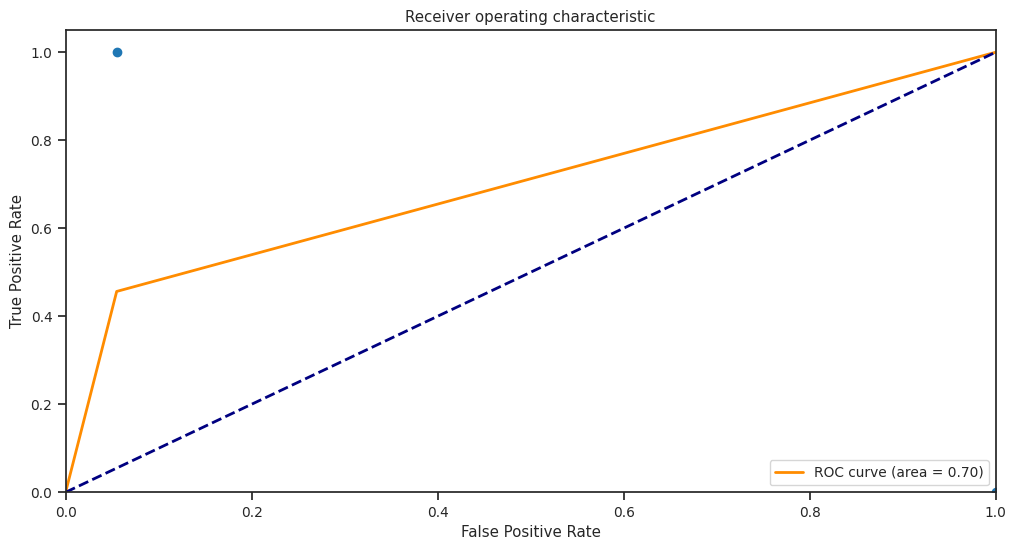

In [ ]:
fpr, tpr, thresholds = roc_curve(hamburguesas_val_dev_target_enc, predictions)

display(fpr)
display(tpr)
display(thresholds)

plot_roc(fpr, tpr, thresholds)

Vemos la matriz de confusión de nuestro modelo

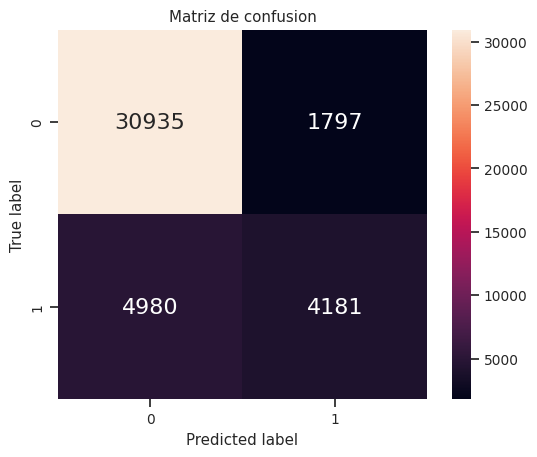

In [ ]:
plot_confusion_matrix(hamburguesas_val_dev_target_enc, predictions)

En este caso, la tendencia del modelo es que tiende a predecir 0 sobre 1 porque si vemos la otra diagonal (la de "pifiadas") vemos que hay más casos de era 1 y lo predijo como 0, respecto de era 0 y lo predijo como 1. Por otro lado, la diagonal principal, es "saludable" pero no tanto, pues hay una diferencia muy alta entre los casos en los que era 0 y predijo 0 respecto de los de la otra diagonal pero no sucedió lo mismo en los casos en los que era 1 y predijo 1 (es bastante mayor que en era 0 y predijo 1 pero un poco menor que en era 1 y predijo 0). 

El modelo predijo bien más positivos (35915 casos, 85,73%) que negativos (5978 casos, 14,27%) porque hay una gran cantidad de verdaderos positivos y (en menor medida) falsos positivos, mientras que los verdaderos negativos y falsos negativos hay menos.

Guardamos las predicciones del modelo

In [ ]:
conversion_features_dataset(hamburguesas_test)

hamburguesas_test_sn = knn_imputer(None, None, None, hamburguesas_test, True)
hamburguesas_test_escalado = standar_scaler(hamburguesas_test_sn)
hamburguesas_test_sin_barrio = binary_encoding(hamburguesas_test_escalado)
hamburguesas_test_bin = one_hot_encoding(hamburguesas_test_sin_barrio)

predicciones = modelo.predict(hamburguesas_test_bin)

In [ ]:
auxiliar = hamburguesas_test.join(hamburguesas_target).reset_index()
auxiliar = auxiliar[['id', 'llovieron_hamburguesas_al_dia_siguiente']]
auxiliar = auxiliar.set_index('id')

nuestra_prediccion = pd.DataFrame(data=predicciones, columns=auxiliar.columns, index=auxiliar.index)

for v in nuestra_prediccion.columns:
  nuestra_prediccion.loc[:, v] = nuestra_prediccion[v].map({0: 'no', 1: 'si',})

nuestra_prediccion.to_csv(PATH_DRIVE_TP_PREDICCIONES + '/decision_tree_knn_imputer_standar_scaler_ohe_bin.csv')

## MeanImputer - Robust Scaler - One Hot Encoding con Binary encoding

Hago el encoding de mis dataset

In [ ]:
hamburguesas_train_values_bin, hamburguesas_val_dev_values_bin, X_test_holdout_sn = preprocessing_mean_imputer_robust_escaler_one_hot_encoding_binary_encoding(
    X_train, 
    X_val_dev, 
    X_test_holdout
)

In [ ]:
hamburguesas_train_target_enc = y_train.llovieron_hamburguesas_al_dia_siguiente.map({'no': 0, 'si': 1, np.NaN: 0})
hamburguesas_val_dev_target_enc = y_val_dev.llovieron_hamburguesas_al_dia_siguiente.map({'no': 0, 'si': 1, np.NaN: 0})

Busco los hiperparametros de mi modelo

In [ ]:
model = DecisionTreeClassifier()

hiperparametros = computar_mejores_hiperparametros(
    model = model, 
    hiperparametros = hiperparametros_a_buscar, 
    X_train = hamburguesas_train_values_bin, 
    y_train = hamburguesas_train_target_enc
)

hiperparametros

Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV 1/5] END ...max_depth=1, min_samples_leaf=1;, score=0.670 total time=   0.1s
[CV 2/5] END ...max_depth=1, min_samples_leaf=1;, score=0.672 total time=   0.1s
[CV 3/5] END ...max_depth=1, min_samples_leaf=1;, score=0.692 total time=   0.1s
[CV 4/5] END ...max_depth=1, min_samples_leaf=1;, score=0.677 total time=   0.1s
[CV 5/5] END ...max_depth=1, min_samples_leaf=1;, score=0.672 total time=   0.1s
[CV 1/5] END ...max_depth=1, min_samples_leaf=3;, score=0.670 total time=   0.1s
[CV 2/5] END ...max_depth=1, min_samples_leaf=3;, score=0.672 total time=   0.1s
[CV 3/5] END ...max_depth=1, min_samples_leaf=3;, score=0.692 total time=   0.1s
[CV 4/5] END ...max_depth=1, min_samples_leaf=3;, score=0.677 total time=   0.1s
[CV 5/5] END ...max_depth=1, min_samples_leaf=3;, score=0.672 total time=   0.1s
[CV 1/5] END ...max_depth=1, min_samples_leaf=5;, score=0.670 total time=   0.1s
[CV 2/5] END ...max_depth=1, min_samples_leaf=5

{'max_depth': 6, 'min_samples_leaf': 11}

In [ ]:
hamburguesas_train_values_bin.drop(labels='barrio_4', axis=1, inplace=True)

In [ ]:
modelo = DecisionTreeClassifier(**hiperparametros)
modelo.fit(hamburguesas_train_values_bin, hamburguesas_train_target_enc)

DecisionTreeClassifier(max_depth=6, min_samples_leaf=11)

Obtengo las predicciones de mi modelo

In [ ]:
predictions = modelo.predict(hamburguesas_val_dev_values_bin)

#### Métricas del modelo

Los valores de las métricas mas usadas son los siguientes:

In [ ]:
show_metrics_values(hamburguesas_val_dev_target_enc, predictions)

ROC AUC Score 0.6925479626926696
Accuracy Score 0.8394242474876471
Precision Score 0.7224049707602339
Recall Score 0.43150311101408145
F1 Score 0.5402856557096973


Veo la curva ROC, sabiendo que AUC es aproximadamente 0.71 segundo lo obtenido líneas arriba

array([0.        , 0.04640719, 1.        ])

array([0.        , 0.43150311, 1.        ])

array([2, 1, 0])

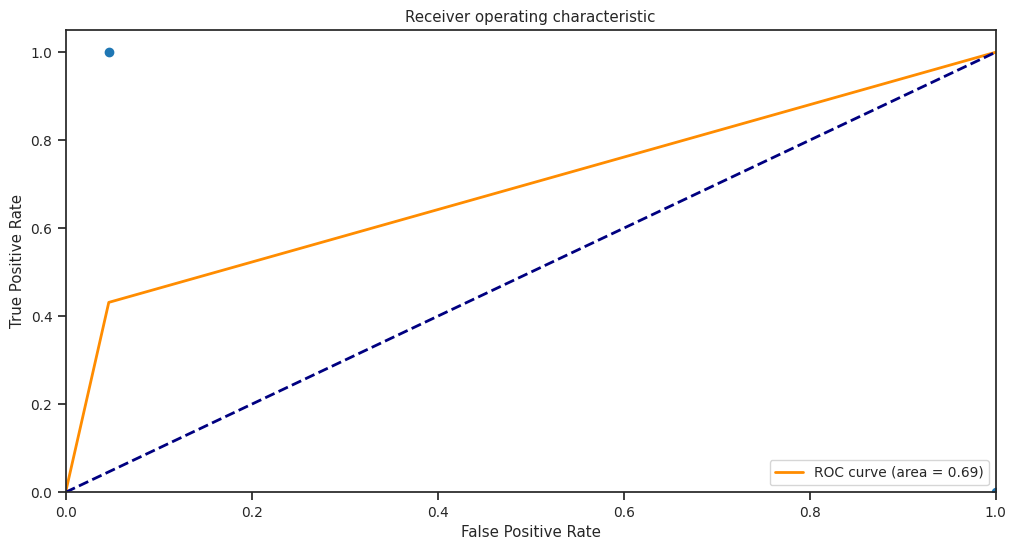

In [ ]:
fpr, tpr, thresholds = roc_curve(hamburguesas_val_dev_target_enc, predictions)

display(fpr)
display(tpr)
display(thresholds)

plot_roc(fpr, tpr, thresholds)

Vemos la matriz de confusión de nuestro modelo

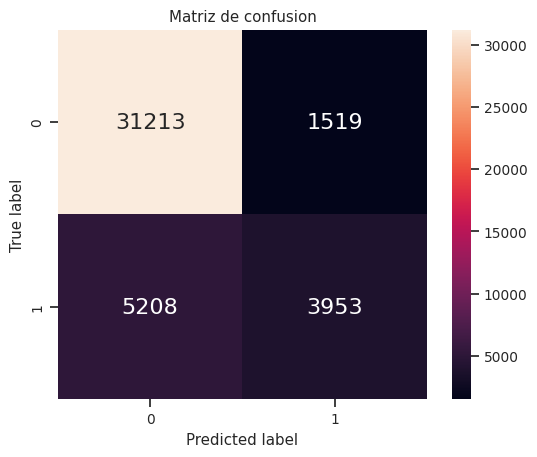

In [ ]:
plot_confusion_matrix(hamburguesas_val_dev_target_enc, predictions)

La matriz de confusion nos muestra nuestros $tp$ (verdaderos positivos), $fp$ (falsos positivos), $tn$ (verdaderos negativos) y $fn$ (falsos negativos) en una matriz. 
La diagonal principal son los valores correctamente clasificados, los otros valores indican la cantidad de puntos mal clasificados.

Guardamos las predicciones del modelo

In [ ]:
conversion_features_dataset(hamburguesas_test)

hamburguesas_test_sn = mean_imputer(None, None, None, hamburguesas_test, True)
hamburguesas_test_escalado = robust_scaler(hamburguesas_test_sn)
hamburguesas_test_sin_barrio = binary_encoding(hamburguesas_test_escalado)
hamburguesas_test_bin = one_hot_encoding(hamburguesas_test_sin_barrio)

predicciones = modelo.predict(hamburguesas_test_bin)

In [ ]:
auxiliar = hamburguesas_test.join(hamburguesas_target).reset_index()
auxiliar = auxiliar[['id', 'llovieron_hamburguesas_al_dia_siguiente']]
auxiliar = auxiliar.set_index('id')

nuestra_prediccion = pd.DataFrame(data=predicciones, columns=auxiliar.columns, index=auxiliar.index)

for v in nuestra_prediccion.columns:
  nuestra_prediccion.loc[:, v] = nuestra_prediccion[v].map({0: 'no', 1: 'si',})

nuestra_prediccion.to_csv(PATH_DRIVE_TP_PREDICCIONES + '/decision_tree_mean_imputer_robust_scaler_ohe_ht.csv')